### **Case 3**: Fitting gravity acceleration from points over an eccentric orbit

In [3]:
import os
import numpy as np
import pyshtools as sh
import matplotlib.pyplot as plt

import spherical_inr as sph
import spherical_inr.differentiation as D
import torch

import scripts
from scripts._units import *

### Settings

In [4]:
out_name = "eccentric_trajectory" # outputs destination folder (a subfolder of out)
out_path = os.path.join("out", out_name)
if not os.path.exists(out_path):
    os.makedirs(out_path)

In [5]:
partials_func = scripts.pot_cnm_partials 
rng = np.random.default_rng()

### Ground-truth gravity
As in the previous notebook, we select as ground-truth the gravity coefficients of Mars, as estimated by Konopliv, et al. (2016), and available on the [NASA PDS](https://pds-geosciences.wustl.edu/mro/mro-m-rss-5-sdp-v1/mrors_1xxx/data/shadr/). 

In [6]:
L_gt = 120 # macimum degree of the coefficients used to simulate the measurements
L_est = 100 # maximum degree of the coefficients to be estimated

# Read SH coefficients, and cut to L_gt
file_name = "spice/data/jgmro_120d_sha.tab"
coeffs, r_0, gm = scripts.read_SHADR(file_name)
cnm_gt = coeffs[:, : L_gt + 1, : L_gt + 1]

# Index array and dictionary to go from a matrix of Cnm to a 1D array, and vice-versa
cnm_idx_sim, cnm_map_sim = scripts.get_cnm_idx(L_gt)
cnm_idx_est, cnm_map_est = scripts.get_cnm_idx(L_est)

### Measurements schedule
This section is used to pick measurement points among those describing a trajctory. The choice of the measurement time-tags is inspired by tracking schedules for radio-tracking observations. For example, we can select to pick 4 hours (`pass_length`) of contiguous points, 60-s apart from each other (`dt`), once every day (`passes_per_day=1`) and at random times during each day (`random_track_start=True`). All this over 1 Earth year (`t_span`).

In [7]:
t_vec = scripts.measurement_schedule(
        t_span=365 * day, dt = 60.* sec, passes_per_day=1, pass_length=4 * hour, random_track_start=True, rng=rng
    )
n_msr_pts = t_vec.shape[0]
print("{:d} measurements selected over {:.2f} days".format(n_msr_pts, t_vec[-1]/day))    

100%|██████████| 365/365 [00:00<00:00, 852880.76it/s]

87600 measurements selected over 364.92 days


### Training & Testing Data

In [59]:
e_mex = 0.57
r_p_mex = 234*km+r_0 # 298 km before ? 
a_mex = r_p_mex/(1-e_mex)


xyz_coords_train, sph_coords_train, t_vec = scripts.points_from_keplerian_traj(
    gm,
    t_vec,  
    coverage=1.0, 
    elts=dict(
        a=a_mex, i=92.6 * deg, e=e_mex, om=270 * deg, Om=0.0 * deg, M_0=0.0 * deg
    ),
)

xyz_coords_test, sph_coords_test = scripts.points_from_grid(L_gt, r=(r_0 * 1.1), use_GLQ_grid=True)

In [60]:
pot_train, acc_train = [
    el * gm for el in scripts.compute_pot_acc(cnm_gt, r_0, sph_coords_train)
]

100%|██████████| 121/121 [23:59<00:00, 11.89s/it] 


In [61]:
pot_test, acc_test = [
    el * gm for el in scripts.compute_pot_acc(cnm_gt, r_0, sph_coords_test)
]

100%|██████████| 121/121 [00:36<00:00,  3.30it/s]


### Storing results

In [11]:
# Saving measurements evaluated on a spherical grid
grid_train_file = "acc_train"
scripts.save_msr_grid(
    os.path.join(out_path, grid_train_file + ".pkl"),
    sph_coords_train,
    acc_train,
)

grid_pot_train_file = "pot_train"
scripts.save_msr_grid(
    os.path.join(out_path, grid_pot_train_file + ".pkl"),
    sph_coords_train,
    pot_train,
)

grid_gt_file = "pot_test"
scripts.save_msr_grid(
    os.path.join(out_path, grid_gt_file + ".pkl"),
    sph_coords_test,
    pot_test,
)

### Retrieve

In [89]:
grid_train_file = "acc_train"
sph_coords_train, acc_train = scripts.read_msr_grid(
    os.path.join(out_path, grid_train_file + ".pkl")
)

grid_pot_train_file = "pot_train"
_, pot_train = scripts.read_msr_grid(
    os.path.join(out_path, grid_pot_train_file + ".pkl")
)

grid_gt_file = "pot_test"
sph_coords_test, pot_test = scripts.read_msr_grid(
    os.path.join(out_path, grid_gt_file + ".pkl")
)


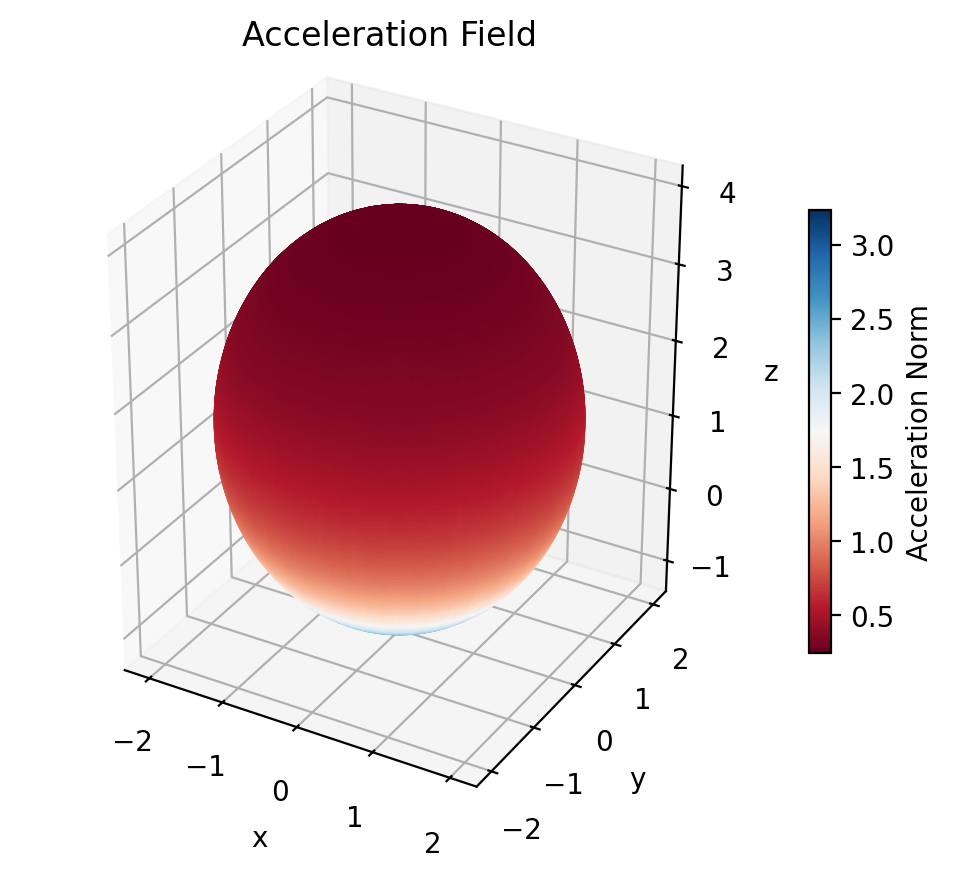

In [88]:
r   = sph_coords_train[:, 0]
th  = sph_coords_train[:, 1]  # colatitude in radians
phi = sph_coords_train[:, 2]

x = r * np.sin(th) * np.cos(phi)
y = r * np.sin(th) * np.sin(phi)
z = r * np.cos(th)


fig = plt.figure(dpi=200)
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    xyz_coords_train[:, 0] / r_0,
    xyz_coords_train[:, 1] / r_0,
    xyz_coords_train[:, 2] / r_0,
    c=np.linalg.norm(acc_train, axis=-1),
    cmap="RdBu"
)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_aspect('equal')
plt.title("Acceleration Field")

cbar = fig.colorbar(sc, ax=ax, shrink=0.6)
cbar.set_label("Acceleration Norm")


plt.show()

## HNET

In [13]:
model_path = os.path.join("models", out_name)
if not os.path.exists(model_path):
    os.makedirs(model_path)

### Data Preprocessing

We define some reference value for the radius, potential and acceleration to later un-dimensionalize them. 

In [90]:
r_star =(r_0 + 234.0 * km)
u_star = gm / r_star
a_star = u_star / r_star

print(
    f"u_star = {u_star} [m^2/s^2]",
    f"r_star = {r_star} [m]",
    f"a_star = {a_star} [m/s^2]",
    sep="\n"
)

u_star = 11798450.63794934 [m^2/s^2]
r_star = 3630000.0 [m]
a_star = 3.2502618837326005 [m/s^2]


Deep Learning model needs to work with scaled data

In [91]:
pot_train_scaled = pot_train.copy().reshape(-1, 1) / u_star
acc_train_scaled = acc_train.copy() / a_star

pot_test_scaled = pot_test.copy().reshape(-1, 1) / u_star

sph_coords_train_scaled = sph_coords_train.copy()
sph_coords_train_scaled[:, 0] /= r_star

sph_coords_test_scaled = sph_coords_test.copy()
sph_coords_test_scaled[:, 0] /= r_star

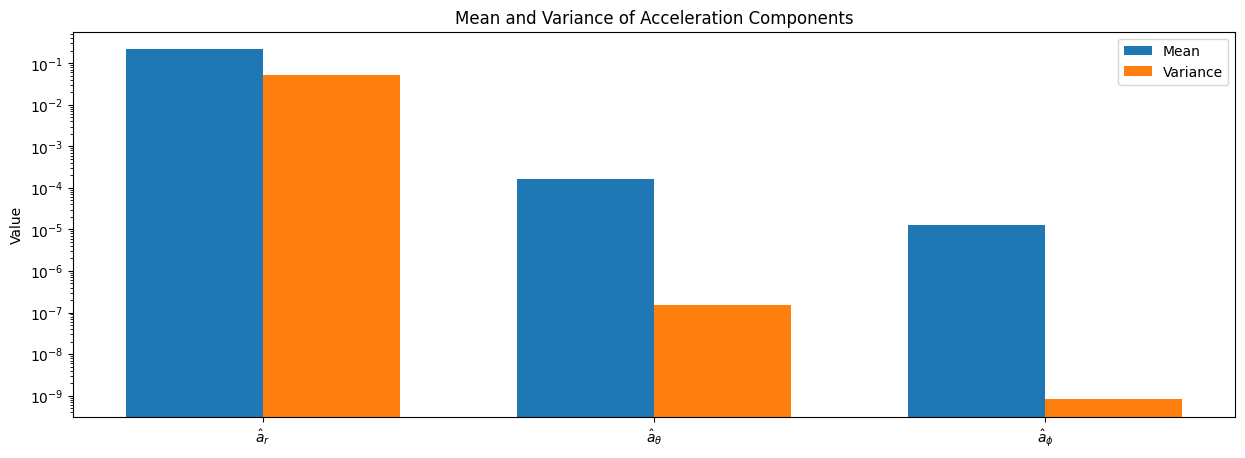

In [92]:
# Compute mean and variance for each component of the acceleration (spherical frame)
mean_vals = np.mean(np.abs(acc_train_scaled), axis=0)
var_vals = np.var(acc_train_scaled, axis=0)
labels_acc = [r'$\hat{a}_{r}$', r'$\hat{a}_{\theta}$', r'$\hat{a}_{\phi}$']

fig, ax1 = plt.subplots(1, 1, figsize=(15, 5))


x = np.arange(len(labels_acc))
width = 0.35  # width of the bars

ax1.bar(x - width/2, mean_vals, width, label='Mean')
ax1.bar(x + width/2, var_vals, width, label='Variance')
ax1.set_ylabel('Value')
ax1.set_title('Mean and Variance of Acceleration Components')
ax1.set_xticks(x)
ax1.set_xticklabels(labels_acc)
ax1.legend()
ax1.set_yscale('log')

plt.show()

In [116]:
xtrain = torch.tensor(sph_coords_train_scaled.copy(), dtype=torch.float32).requires_grad_(True)
ytrain = torch.tensor(acc_train_scaled.copy(), dtype=torch.float32)

xtest = torch.tensor(sph_coords_test_scaled.copy(), dtype=torch.float32)
ytest = torch.tensor(pot_test_scaled.copy(), dtype=torch.float32)

In [117]:
def gen_random_s2(n : int):
    v = torch.randn(n, 3)
    v /= torch.norm(v, dim=1).reshape(-1, 1)
    r = torch.tensor(20.0*np.random.uniform(1e-2, 1, n)**(1/3), dtype=torch.float32)
    
    
    theta = torch.acos(v[:, 2])
    phi = torch.atan2(v[:, 1], v[:, 0])
    v = torch.stack((r, theta, phi), dim=1)
    return v

### Model

In [164]:
class ModifiedHHNET(sph.INR):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.rref = torch.nn.Parameter(torch.tensor(1.0, dtype=torch.float32))
        

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x= sph.transforms.rsph2_to_cart3(x)
        x = self.pe(x/self.rref)
        x = self.mlp(x)
        return x
        

hnet= ModifiedHHNET(
    input_dim=3,
    output_dim = 1, 
    inr_sizes = [200] + 4*[100],
    pe = "irregular_herglotz",
    activation = "relu",
    bias= False,  
)

### Loss

In [165]:
def loss_modified(target, output, input, alpha_t = 1e4, alpha_p = 1e5):
    
    ddr, ddt, ddp = D.spherical_gradient(output, input, track=True).unbind(-1)
    target_r, target_t, target_p = target.unbind(-1)
    scale = target_r.abs()
    loss = torch.nn.functional.mse_loss(ddr/scale, target_r/scale) + alpha_t * torch.nn.functional.mse_loss(ddt, target_t) + alpha_p*torch.nn.functional.mse_loss(ddp, target_p)

    return loss

In [166]:
Reg = sph.SphericalLaplacianLoss()
MSE = torch.nn.MSELoss()

def loss_fn(target, output, input, yreg, xreg):
    return loss_modified(target, output, input) #+  1e2*Reg(yreg, xreg)
    

### Training

In [168]:
epoch = 1000
batch_size = 4096
lr = 1e-2
optimizer = torch.optim.Adam(hnet.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epoch)

In [ ]:
dataset = torch.utils.data.TensorDataset(xtrain, ytrain)
dataloader =torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

hnet.train()
for ep in range(epoch):
    epoch_loss = 0.0
    xreg = gen_random_s2(1000).requires_grad_(True)
    for xb, yb in dataloader:
        optimizer.zero_grad()
        ypred = hnet(xb)
        yreg = hnet(xreg)
        loss = loss_fn(yb, ypred, xb, yreg, xreg)
        loss.backward()
        optimizer.step()
        scheduler.step()
        epoch_loss += loss.item()
    epoch_loss /= len(dataloader)
    hnet.eval()
    with torch.no_grad():
        ytest_pred = hnet(xtest)
        val_loss = MSE(ytest_pred, ytest) ** 0.5
    hnet.train()
    
    if ep % 5 == 0:
        print(f"Epoch {ep} Loss {epoch_loss**0.5} Val Loss {val_loss.item()}", end = "\r")

In [174]:
torch.save(hnet.state_dict(), model_path + "/ghet.pth")

In [175]:
hnet.load_state_dict(torch.load(model_path + "/ghet.pth"))
hnet.eval()

ModifiedHHNET(
  (pe): IregularHerglotzPE(num_atoms=200, input_dim=3, omega0=1.0, omega0=1.0)
  (mlp): MLP(
    (hidden_layers): ModuleList(
      (0): Linear(in_features=200, out_features=100, bias=False)
      (1-2): 2 x Linear(in_features=100, out_features=100, bias=False)
      (3): Linear(in_features=100, out_features=1, bias=False)
    )
    (activation): ReLU()
  )
)

In [170]:
def U(x):
    return u_star * (hnet(x).squeeze().detach().numpy())

### Errors

In [171]:
pot_pred = U(xtest)

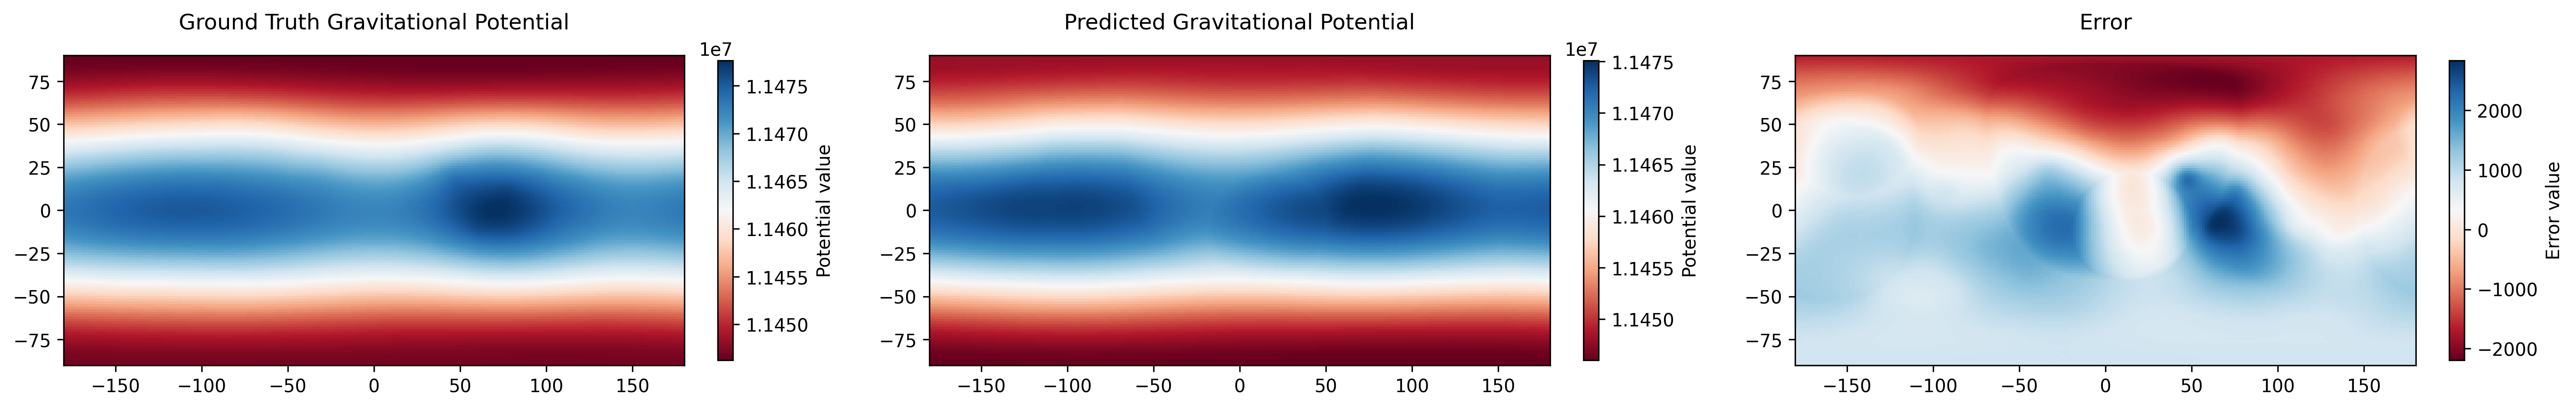

In [172]:
# coeffs = sh.SHCoeffs.from_array(cnm_gt)
data_pred = pot_pred.reshape(  (L_gt+1, 2*(L_gt+1) - 1))
data_test = pot_test.reshape( (L_gt+1, 2*(L_gt+1) - 1))

fig = plt.figure(figsize=(20, 15), dpi = 300)
subfigs = fig.subfigures(1, 3)
scripts.plot_sphere(data_test,   fig= subfigs[0], cmap = "RdBu", title="Ground Truth Gravitational Potential")
ax = subfigs[0].axes[0]
cbar = fig.colorbar(ax.get_images()[0], ax=ax, orientation='vertical', shrink=0.2, fraction = 0.025)
cbar.ax.set_ylabel('Potential value')

scripts.plot_sphere(data_pred,   fig= subfigs[1], cmap = "RdBu", title="Predicted Gravitational Potential")
ax = subfigs[1].axes[0]
cbar = fig.colorbar(ax.get_images()[0], ax=ax, orientation='vertical', shrink=0.2, fraction = 0.025)
cbar.ax.set_ylabel('Potential value')

scripts.plot_sphere(data_test - data_pred,   fig= subfigs[2], cmap = "RdBu", title="Error")
ax = subfigs[2].axes[0]
cbar = fig.colorbar(ax.get_images()[0], ax=ax, orientation='vertical', shrink=0.2, fraction = 0.025)
cbar.ax.set_ylabel('Error value')

plt.show()

In [173]:
errors = (pot_test - pot_pred)
rel_errors = errors / pot_test

error_stats = [
    np.mean(errors),
    np.median(errors),
    np.var(errors),
    np.linalg.norm(errors) / np.sqrt(errors.size),
]
error_stats.append(np.log10(np.abs(np.mean(1 / (rel_errors + 1e-20)))))

print("Error stats: ")
print("Mean: {:.5g} - Median: {:.5g} -  Var : {:5g} - RMS: {:.5g} - SNR (dB):{:.5g}".format(*error_stats))

Error stats: 
Mean: 284.45 - Median: 771.79 -  Var : 1.21749e+06 - RMS: 1139.5 - SNR (dB):4.1085
